# Imports

In [1]:
import sys
import tensorflow as tf
import numpy as np
import itertools
import os

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import pyemma

sys.path.append('gmvae')
from model import GMVAE
from dataset import load_and_mix_data_nolabel

matplotlib.rcParams.update({'font.size': 24})

# Paths

In [2]:
readdir = 'data/'
savedir = 'results/'
modeldir = 'models/'

# Load data

In [3]:
data = np.load(readdir + "traj_mb.npy")
data_list = []
for i in range(data.shape[0]):
    data_list.append(data[i, :, :])
data = data.reshape(len(data)*10000, 2)
dataset = load_and_mix_data_nolabel(data=data, test_ratio=0.01)

In [16]:
data.shape

(300000, 2)

In [20]:
help(dataset)

Help on Dataset in module dataset object:

class Dataset(builtins.object)
 |  Dataset(k)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, k)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  setTestData(self, data, labels=None)
 |  
 |  setTrainData(self, data, labels=None)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [23]:
help(dataset.setTestData)

Help on method setTestData in module dataset:

setTestData(data, labels=None) method of dataset.Dataset instance



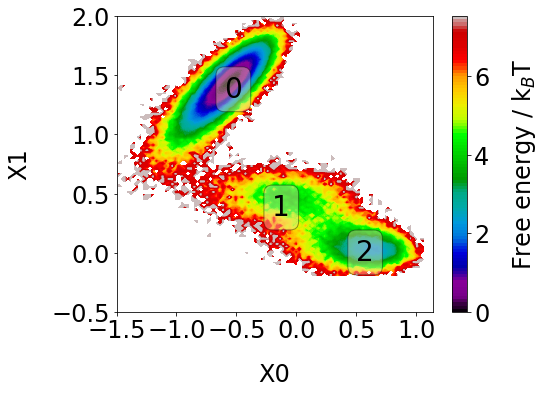

In [4]:
matplotlib.rcParams.update({'font.size': 24})
_, _, misc = pyemma.plots.plot_free_energy(data[:,0], data[:,1], nbins = 100, ncontours = 100, legacy = False)
cbar = misc['cbar']
cbar.set_label('Free energy / k$_{B}$T', labelpad=20)
cbar.set_ticks(np.arange(0, 8, 2))
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlabel('X0', labelpad=20)
plt.ylabel('X1', labelpad=20)
plt.yticks(np.arange(-0.5,2.1,0.5))
plt.xticks(np.arange(-1.5,1.5,0.5))
plt.text(-0.6, 1.5, '0', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.text(-0.2, 0.5, '1', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.text(0.5, 0.12, '2', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.tight_layout()
plt.savefig(savedir + 'FE.png')

# Training

In [5]:
k, n_x, n_z, n_epochs = 5, 2, 1, 401
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.05
batch_size = 5000
lr = 1e-4

model_path = modeldir + 'model_' +str(k)+'_'+str(n_z)+'_'+str(n_epochs)+'_'+str(r_nent)+'_' + str(batch_size)
results = '_results'

if not os.path.exists(model_path):
    os.makedirs(model_path)

results_dir_s = model_path+results

if not os.path.exists(results_dir_s):
    os.makedirs(results_dir_s)
    
results_dir = Path(results_dir_s)
    
model = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent, batch_size=batch_size, lr=lr)
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history, ye, ze = model.train(dataset, sess, epochs=n_epochs,
                                  n_train_eval=200000, n_test_eval=200000, save_parameters=True, 
                                  is_labeled=False, track_losses=True, verbose=True)
    
f = open(model_path + '/training_params.txt','w+')
f.write(f'k={k}, n_x={n_x}, n_z={n_z}, n_epochs={n_epochs}, qy_dims={qy_dims}, qz_dims={qz_dims}, '+
        f'pz_dims={pz_dims}, px_dims={px_dims}, r_ent={r_nent}, batch_size={batch_size}, lr={lr}')
raw_data = {'k': [k], 'n_x': [n_x], 'n_z': [n_z], 'n_epochs': [n_epochs], 'qy_dims': [qy_dims], 'qz_dims': [qz_dims], 'pz_dims': [pz_dims], 
            'px_dims': [px_dims], 'r_nent': [r_nent], 'batch_size': [batch_size], 'lr': [lr]}
df = pd.DataFrame(data=raw_data)
df.to_pickle(model_path + '/training_params.pkl')
f.close()






Instructions for updating:
Please use `layer.__call__` method instead.





graph written




2022-03-02 08:05:28.938579: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-02 08:05:29.539050: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 08:05:29.539394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.65
pciBusID: 0000:09:00.0
2022-03-02 08:05:29.539534: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2022-03-02 08:05:29.539595: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0

2022-03-02 08:05:30.471979: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 08:05:30.472519: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558ed4b324b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-02 08:05:30.472552: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2022-03-02 08:05:30.472679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 08:05:30.472688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


2022-03-02 08:05:33.275059: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 25600000 exceeds 10% of system memory.
2022-03-02 08:05:33.626801: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 102400000 exceeds 10% of system memory.
2022-03-02 08:05:33.656221: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 102400000 exceeds 10% of system memory.
2022-03-02 08:05:33.732922: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 102400000 exceeds 10% of system memory.
2022-03-02 08:05:33.733614: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 102400000 exceeds 10% of system memory.


    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch
  1.60e+00,  4.40e+00,  1.60e+00,  4.27e+00,         1
Sample of qy
0.20 0.21 0.18 0.22 0.18 
0.20 0.22 0.18 0.22 0.18 
0.20 0.22 0.18 0.23 0.17 
0.19 0.23 0.17 0.24 0.16 
0.19 0.23 0.18 0.23 0.17 

epoch:         50                                                                                   
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  3.31e-01,  6.82e-01,  3.29e-01,  7.13e-01,        51
Sample of qy
0.90 0.00 0.00 0.00 0.09 
0.90 0.00 0.00 0.00 0.09 
0.92 0.00 0.00 0.00 0.08 
0.93 0.00 0.00 0.01 0.06 
0.93 0.00 0.00 0.00 0.07 

epoch:        100                                                                                   
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  3.98e-01,  2.48e-01,  3.92e-01,  2.82e-01,       101
Sample of qy
0.24 0.00 0.00 0.00 0.76 
0.53 0.00 0.00 0.00 0.46 
0.85 0.00 0.00 0.00 0.1

Training curve

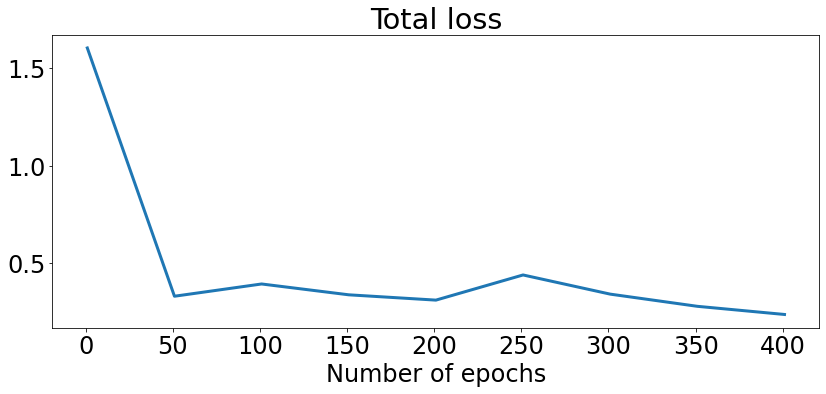

In [6]:
fig, axes = plt.subplots(figsize = (12,6), nrows=1, ncols=1)
axes.plot(history['iters'], history['val_ent'], linewidth = 3.0)
axes.set_title('Total loss')
axes.set_xlabel('Number of epochs')
plt.tight_layout() 
plt.savefig(str(results_dir) + 'training.png')
plt.show()

# Encodings

In [24]:
qy = model.encode_y(data)
y_pred = np.argmax(qy, axis=1)
z = model.encode_z(data)

INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000/model.ckpt-401


2022-03-02 11:18:13.485601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 11:18:13.487114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000/model.ckpt-401


2022-03-02 11:18:14.812684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 11:18:14.812739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000/model.ckpt-401


2022-03-02 11:18:15.553412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 11:18:15.553473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


In [25]:
z

array([[ 2.11091161],
       [ 1.70750308],
       [ 2.44153905],
       ...,
       [-2.79185786],
       [-2.33164531],
       [-2.92720925]])

In [8]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

Distribution of z

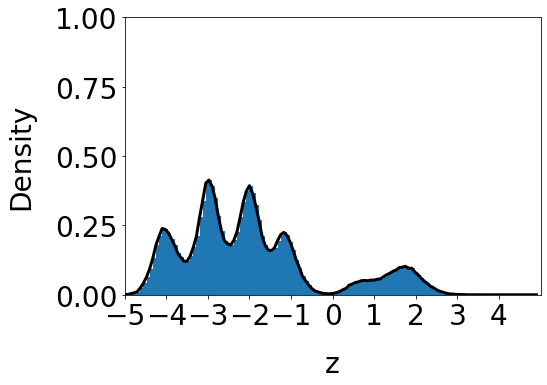

In [9]:
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
_ = plt.hist(z, bins= np.arange(-5, 5, 0.075), density=True)
ah = np.histogram(z, bins= np.arange(-5, 5, 0.075), density=True)
plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
plt.ylabel('Density', labelpad=20)
plt.xlabel('z', labelpad=20)
plt.xticks(np.arange(-5, 5))
plt.xlim([-5,5])
plt.ylim([0, 1])
titlename = 'z_histograms_line'
plt.tight_layout()
plt.savefig(str(results_dir) + '/z_histogram.png', bbox_inches='tight')

GMVAE clusters on the FEL

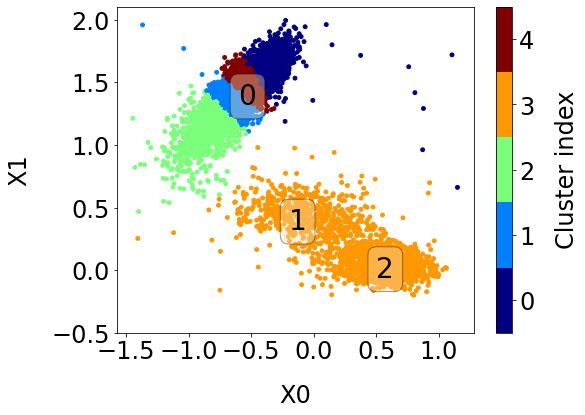

In [10]:
matplotlib.rcParams.update({'font.size': 24})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
i=0
step=20
sc = axes.scatter(data[::step,0], data[::step,1], c=y_pred[::step], alpha=1, 
                  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_alpha(1)
cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Cluster index', labelpad=20)
sc.set_alpha(1)
sc.set_clim(-0.5, len(np.unique(y_pred)) - 0.5)
cbar.draw_all()

axes.set_xlabel('X0', labelpad=20)
axes.set_ylabel('X1', labelpad=20)
axes.set_yticks(np.arange(-0.5,2.1,0.5))
axes.set_xticks(np.arange(-1.5,1.5,0.5))

axes.text(-0.6, 1.5, '0', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
axes.text(-0.2, 0.5, '1', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
axes.text(0.5, 0.12, '2', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
fig.savefig(str(results_dir) + '/GMVAE_clusters.png', bbox_inches='tight')

Reconstructions

INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000/model.ckpt-401


2022-03-02 08:25:44.914280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 08:25:44.914335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000/model.ckpt-401


2022-03-02 08:25:46.835087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-02 08:25:46.835151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


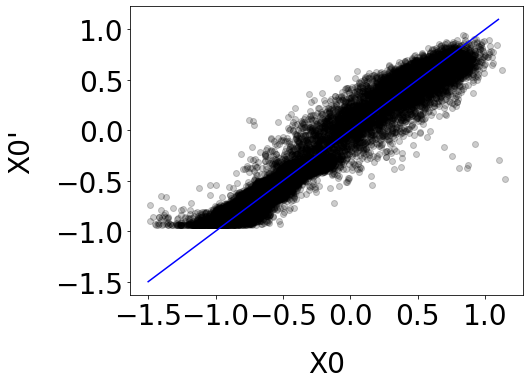

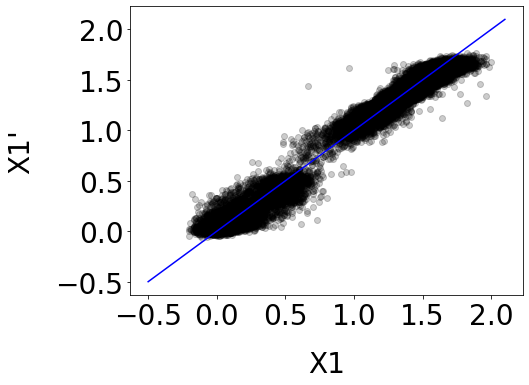

In [11]:
matplotlib.rcParams.update({'font.size': 28})

plt.figure(figsize=(8,6))
x = model.reconstruct(data)
plt.scatter(data[::5,0], x[::5,0], color = 'k', alpha=0.2)
plt.xlabel("X0", labelpad=20)
plt.ylabel("X0'", labelpad=20)
lims = [-1.5, 1.1]
plt.plot(lims, lims, 'b-', alpha=1)
plt.xticks(np.arange(-1.5, 1.1, step=0.5))
plt.yticks(np.arange(-1.5, 1.1, step=0.5))
plt.tight_layout()
plt.savefig(str(results_dir) + '/reconst_X0.png')

plt.figure(figsize=(8,6))
plt.scatter(data[::5,1], x[::5,1], color = 'k', alpha=0.2)
plt.xlabel("X1", labelpad=20)
plt.ylabel("X1'", labelpad=20)
lims = [-0.5, 2.1]
plt.plot(lims, lims, 'b-', alpha=1)
plt.xticks(np.arange(-0.5, 2.1, step=0.5))
plt.yticks(np.arange(-0.5, 2.1, step=0.5))
plt.tight_layout()
plt.savefig(str(results_dir) + '/reconst_X1.png')


# MSM Analysis

Convert cluster data into list

In [26]:
y_pred_list = []
for i in range(30):
    y_pred_list.append(y_pred[i*10000: (i+1)*10000])

In [30]:
y_pred_list[0].shape

(10000,)

In [31]:
len(y_pred_list)

30

In [32]:
y_pred.shape

(300000,)

Implied timescale test

In [33]:
help(pyemma.msm.its)

Help on function timescales_msm in module pyemma.msm.api:

timescales_msm(dtrajs, lags=None, nits=None, reversible=True, connected=True, weights='empirical', errors=None, nsamples=50, n_jobs=None, show_progress=True, mincount_connectivity='1/n', only_timescales=False, core_set=None, milestoning_method='last_core')
    Implied timescales from Markov state models estimated at a series of lag times.
    
    Parameters
    ----------
    dtrajs : array-like or list of array-likes
        discrete trajectories
    
    lags : int, array-like with integers or None, optional
        integer lag times at which the implied timescales will be calculated. If set to None (default)
        as list of lag times will be automatically generated. For a single int, generate a set of lag times starting
        from 1 to lags, using a multiplier of 1.5 between successive lags.
    
    nits : int, optional
        number of implied timescales to be computed. Will compute less
        if the number of sta

estimating BayesianMSM:   0%|                                                                     | 0/9 [00:00…

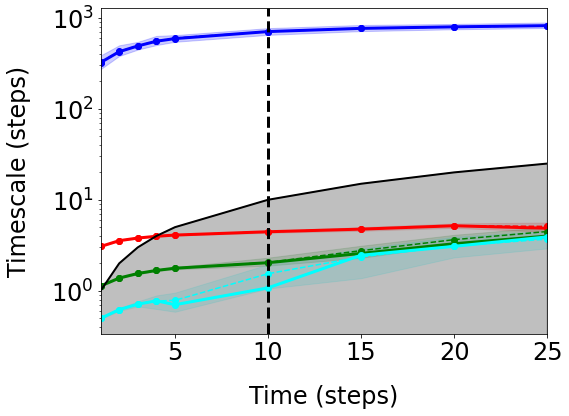

In [13]:
plt.rcParams.update({'font.size': 24})
cklag = 10
its = pyemma.msm.its(y_pred_list, lags=[1, 2, 3, 4, 5, 10, 15, 20, 25], errors='bayes')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize=(8,6))
pyemma.plots.plot_implied_timescales(its, marker = 'o', ylog=True, units='steps', ax = axes, linewidth=3)
axes.axvline(cklag, color ='black', linewidth = 3, linestyle='--'  )
titlename = "its"
axes.set_xlabel('Time (steps)', labelpad=20)
axes.set_ylabel('Timescale (steps)', labelpad=20)
fig.savefig(str(results_dir) + '/its.png', bbox_inches='tight')

Chapman-Kolmogorov test

estimating MaximumLikelihoodMSM:   0%|                                                            | 0/9 [00:00…

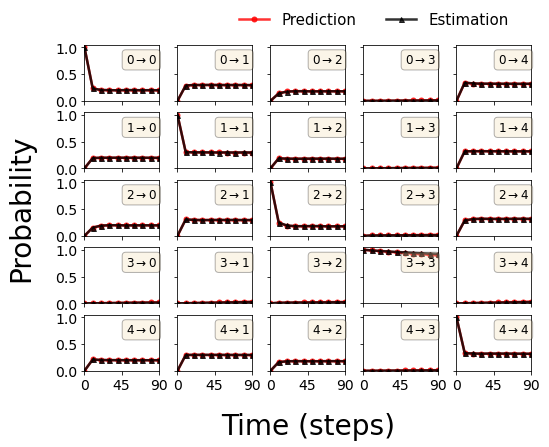

In [15]:
cklag =10
nc = 5
matplotlib.rcParams.update({'font.size': 14})
msm = pyemma.msm.estimate_markov_model(y_pred_list, lag=cklag, dt_traj='1 ps')
cktestobj = msm.cktest(nc, memberships =np.eye(nc))
fig, axes = plt.subplots(figsize=(8,6), nrows=nc, ncols=nc, sharex = True, sharey=True)
axes=axes.ravel()
xlimits=[0, cklag*9]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

for k in range(nc**2):
    j=k%nc
    i=k//nc
    axes[k].plot(cktestobj.lagtimes, cktestobj.predictions[:, i, j], color='red',
                 linewidth=2.5, alpha = 0.8, marker='o', markersize=5, linestyle='-', label='Prediction')
    axes[k].plot(cktestobj.lagtimes, cktestobj.estimates[:, i, j], color='black',
                 linewidth=2.5, alpha = 0.8, marker="^", markersize=5, label='Estimation')
    axes[k].text(cklag*5, 0.7, str(i)+r'$\rightarrow$'+str(j), fontsize=12, bbox=props)
    axes[k].set_ylim([0, 1.05])
    axes[k].set_xlim([0, cklag*9])
    axes[k].set_xticks(np.arange(xlimits[0], xlimits[1]+0.1, xlimits[1]//2, dtype='int'))
    axes[k].set_yticks(np.arange(0, 1.01, 0.5))
titlename = "ck_test"
plt.legend( loc = [-3, 6], ncol=2, frameon=False, fontsize=15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor= 'none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time (steps)', fontsize=28, labelpad=20)
plt.ylabel('Probability', labelpad = 20, fontsize=28)
plt.grid(False)
plt.subplots_adjust(wspace=0.25)
fig.savefig(str(results_dir)+'/gmvae_ck.png', bbox_inches='tight')